In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Load saved models from Drive
model_cnn = load_model('/content/drive/MyDrive/PneumoScan/custom_cnn_pneumoscan.keras')
model_vgg = load_model('/content/drive/MyDrive/PneumoScan/vgg16_pneumoscan.keras')
model_vgg_ft = load_model('/content/drive/MyDrive/PneumoScan/vgg16_finetuned_pneumoscan.keras')


Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"trayharoun","key":"e6989c8bbfd23f1adf81ba878e7f91ce"}'}

In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d .


Streaming output truncated to the last 5000 lines.
  inflating: ./chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/

In [12]:
# Define path to test data
test_path = "/content/chest_xray/test"

# Rescale only
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 624 images belonging to 2 classes.


In [13]:
# Reset test generator
test_gen.reset()
y_true = test_gen.classes

# Predict with all 3 models
y_pred_cnn = (model_cnn.predict(test_gen) > 0.5).astype("int32").flatten()
y_pred_vgg = (model_vgg.predict(test_gen) > 0.5).astype("int32").flatten()
y_pred_vgg_ft = (model_vgg_ft.predict(test_gen) > 0.5).astype("int32").flatten()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 450s 22s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 448s 22s/step


In [14]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n🔍 Evaluation for: {model_name}")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix – {model_name}")
    plt.show()
    print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))



🔍 Evaluation for: Custom CNN


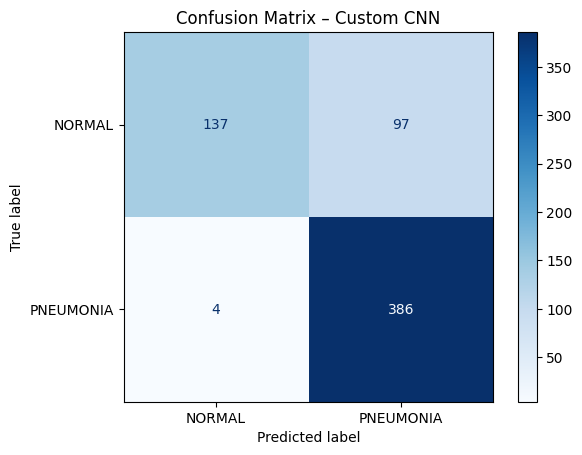

              precision    recall  f1-score   support

      NORMAL       0.97      0.59      0.73       234
   PNEUMONIA       0.80      0.99      0.88       390

    accuracy                           0.84       624
   macro avg       0.89      0.79      0.81       624
weighted avg       0.86      0.84      0.83       624


🔍 Evaluation for: VGG16 (Frozen)


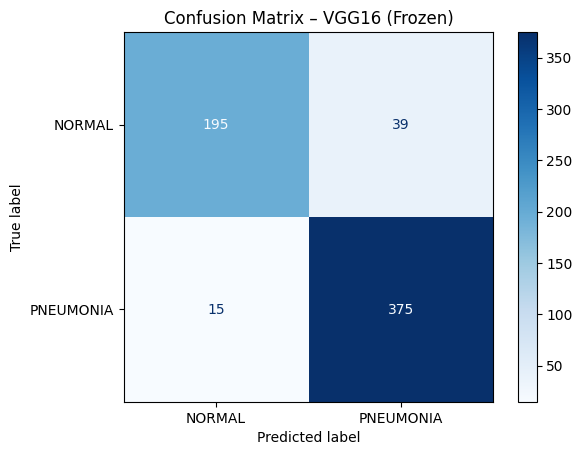

              precision    recall  f1-score   support

      NORMAL       0.93      0.83      0.88       234
   PNEUMONIA       0.91      0.96      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.91      0.91      0.91       624


🔍 Evaluation for: VGG16 (Fine-Tuned)


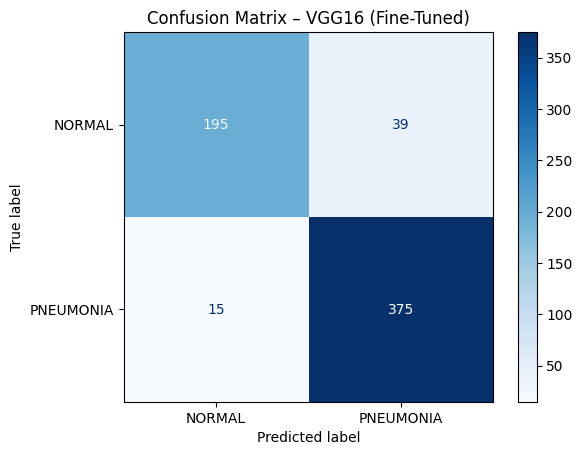

              precision    recall  f1-score   support

      NORMAL       0.93      0.83      0.88       234
   PNEUMONIA       0.91      0.96      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.91      0.91      0.91       624



In [15]:
evaluate_model(y_true, y_pred_cnn, "Custom CNN")
evaluate_model(y_true, y_pred_vgg, "VGG16 (Frozen)")
evaluate_model(y_true, y_pred_vgg_ft, "VGG16 (Fine-Tuned)")
